# Projet : Analyse des données de santé mentale étudiante
## 1) Introduction & Contexte
La santé mentale étudiante est un enjeu majeur contemporain. Après la pandémie de COVID-19, on observe une augmentation notable des troubles liés au stress, à l'anxiété et à la dépression chez les étudiants, accentuée par la pression académique, l'isolement social et l'incertitude professionnelle.
Ce projet vise à explorer des motifs et des corrélations dans un dataset auto-déclaré, afin d'éclairer des pistes d'intervention à l'échelle institutionnelle. This project does not aim to diagnose or medically interpret mental disorders, but to explore patterns and correlations within self-reported datasets.
Les analyses présentées ici mettent l'accent sur des corrélations observées et non sur des relations causales.

## 2) Data Collection
Présentation du dataset fourni (Kaggle) : fichier `data/raw/Student Mental health.csv`.
- Format : CSV
- Ce dataset est basé sur des réponses auto-déclarées (self-report) — des biais sont possibles (culturels, sociaux, anonymat).
- Nous indiquons ci-dessous le nombre de lignes/colonnes et les variables détectées automatiquement.

In [6]:
# Import des bibliothèques principales
# Commentaires et prints en français
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

print('Lecture du dataset depuis : data/raw/Student Mental health.csv')
path = 'data/raw/Student Mental health.csv'
try:
    df = pd.read_csv(path)
    print(f'Dataset chargé avec succès — shape: {df.shape}')
    print('Colonnes détectées :', list(df.columns))
except Exception as e:
    print('Erreur lors de la lecture du fichier :', e)
    df = pd.DataFrame()


Lecture du dataset depuis : data/raw/Student Mental health.csv
Dataset chargé avec succès — shape: (101, 11)
Colonnes détectées : ['Timestamp', 'Choose your gender', 'Age', 'What is your course?', 'Your current year of Study', 'What is your CGPA?', 'Marital status', 'Do you have Depression?', 'Do you have Anxiety?', 'Do you have Panic attack?', 'Did you seek any specialist for a treatment?']


## 3) Data Cleaning & Preprocessing
Nous allons :
- Vérifier les valeurs manquantes et afficher les pourcentages
- Normaliser les réponses binaires (Yes/No) et Likert si présent
- Encoder les variables catégorielles si nécessaire

In [ ]:
# Analyse des valeurs manquantes et types
if df.empty:
    print('DataFrame vide, vérifiez le chemin du fichier.')
else:
    missing = df.isnull().mean() * 100
    print('Pourcentage de valeurs manquantes par colonne (les colonnes >50% seront listées) :')
    print(missing[missing>0].sort_values(ascending=False).head(20).round(2))
    cols_drop = list(missing[missing>50].index)
    print(f'Colonnes suggérées pour suppression (>{50}% de NA) : {cols_drop}')
    # Exemples de normalisation : Yes/No -> 1/0 ; détecter automatiquement quelques patterns
    df_clean = df.copy()
    # Normaliser les réponses Yes/No
    for col in df_clean.columns:
        if df_clean[col].dropna().isin(['Yes','No','yes','no','Y','N']).all():
            df_clean[col] = df_clean[col].map(lambda x: 1 if str(x).lower().startswith('y') else (0 if str(x).lower().startswith('n') else np.nan))
            print(f'Normalisé Yes/No pour la colonne: {col}')
    # Exemple de normalisation simple pour Likert si présent
    likert_map = {'Never':0,'Rarely':1,'Sometimes':2,'Often':3,'Always':4,'Jamais':0,'Rarement':1,'Parfois':2,'Souvent':3,'Toujours':4}
    for col in df_clean.columns:
        uniques = df_clean[col].dropna().unique()
        if any(isinstance(u, str) and u in likert_map for u in uniques):
            df_clean[col] = df_clean[col].map(lambda x: likert_map.get(x, x))
            print(f"Application d'une cartographie Likert sur la colonne: {col}")
    # Encodage des catégories avec pandas.get_dummies si trop de catégories non numériques
    # Pour la suite, on conservera les colonnes numériques et quelques colonnes catégorielles d'intérêt
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    print('Colonnes numériques conservées pour analyses statistiques :', numeric_cols)
    # Sauvegarde du DataFrame nettoyé dans data/clean
    try:
        clean_dir = os.path.join('data', 'clean')
        os.makedirs(clean_dir, exist_ok=True)
        clean_file = os.path.join(clean_dir, 'Student_Mental_health_clean.csv')
        df_clean.to_csv(clean_file, index=False)
        print(f'Data nettoyée enregistrée sous : {clean_file} : {df_clean.shape}')
    except Exception as e:
        print('Erreur lors de la sauvegarde du fichier nettoyé :', e)


Pourcentage de valeurs manquantes par colonne (les colonnes >50% seront listées) :
Age    0.99
dtype: float64
Colonnes suggérées pour suppression (>50% de NA) : []
Normalisé Yes/No pour la colonne: Marital status
Normalisé Yes/No pour la colonne: Do you have Depression?
Normalisé Yes/No pour la colonne: Do you have Anxiety?
Normalisé Yes/No pour la colonne: Do you have Panic attack?
Normalisé Yes/No pour la colonne: Did you seek any specialist for a treatment?
Colonnes numériques conservées pour analyses statistiques : ['Age', 'Marital status', 'Do you have Depression?', 'Do you have Anxiety?', 'Do you have Panic attack?', 'Did you seek any specialist for a treatment?']
Data nettoyée enregistrée sous : data\clean\Student_Mental_health_clean.csv — shape: (101, 11)


### Statistiques intermédiaires
Affichage des pourcentages de données manquantes et des décisions de suppression/conservation.

In [8]:
if not df.empty:
    total_missing_pct = df.isnull().mean().mean() * 100
    print(f'% total moyen de valeurs manquantes (moyenne par colonne) : {total_missing_pct:.2f}%')
    kept = [c for c in df_clean.columns if c not in cols_drop] if 'cols_drop' in locals() else list(df_clean.columns)
    print(f'Nombre de colonnes conservées : {len(kept)} / {df.shape[1]}')
    print('Colonnes conservées (extrait) :', kept[:20])

% total moyen de valeurs manquantes (moyenne par colonne) : 0.09%
Nombre de colonnes conservées : 11 / 11
Colonnes conservées (extrait) : ['Timestamp', 'Choose your gender', 'Age', 'What is your course?', 'Your current year of Study', 'What is your CGPA?', 'Marital status', 'Do you have Depression?', 'Do you have Anxiety?', 'Do you have Panic attack?', 'Did you seek any specialist for a treatment?']


## 4) Analyse Générale (EDA)
Objectif : comprendre la répartition des réponses et les corrélations potentielles.

Chargé df_clean depuis data\clean\Student_Mental_health_clean.csv — shape: (101, 11)


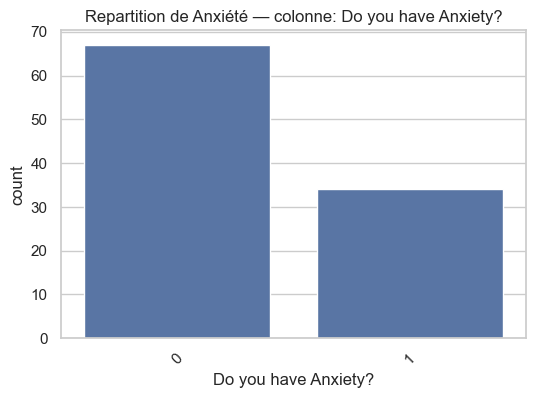

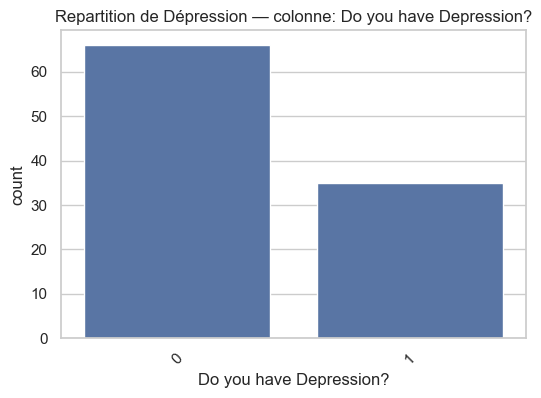

Aucune colonne détectée automatiquement pour Stress


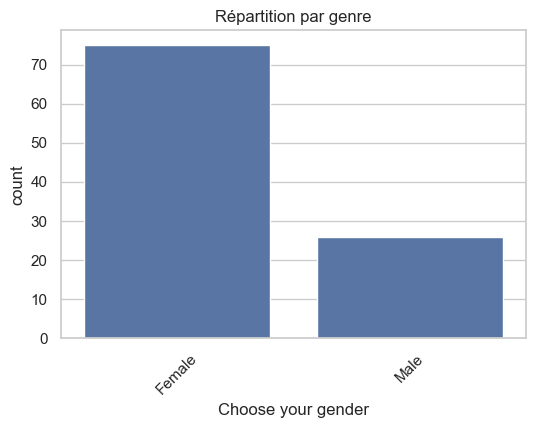

In [ ]:
# Visualisations basiques — gérées de manière robuste si colonnes manquantes
# Si un fichier nettoyé existe, le charger pour garantir la reproductibilité
clean_file = os.path.join('data', 'clean', 'Student_Mental_health_clean.csv')
if os.path.exists(clean_file):
    try:
        df_clean = pd.read_csv(clean_file)
        print(f'Chargé df_clean depuis {clean_file} : {df_clean.shape}')
    except Exception as e:
        print('Erreur lors du chargement du fichier nettoyé :', e)
else:
    print('Fichier nettoyé non trouvé, utilisation de df_clean en mémoire si présent')

if not df.empty:
    sns.set(style='whitegrid')
    # Tentative : trouver une colonne correspondant à la dépression/anxiété/stress
    cols_lower = [c.lower() for c in df_clean.columns]
    def find_col(keywords):
        for i,c in enumerate(cols_lower):
            for k in keywords:
                if k in c:
                    return df_clean.columns[i]
        return None
    col_anxiety = find_col(['anx','anxiety','anxi'])
    col_depress = find_col(['depress','depression'])
    col_stress = find_col(['stress','stres'])
    # Distribution si trouvée
    for name,col in [('Anxiété',col_anxiety),('Dépression',col_depress),('Stress',col_stress)]:
        if col is not None:
            plt.figure(figsize=(6,4))
            sns.countplot(x=df_clean[col].fillna('Missing'))
            plt.title(f'Repartition de {name}, colonne: {col}')
            plt.xticks(rotation=45)
            plt.show()
        else:
            print(f'Aucune colonne détectée automatiquement pour {name}')
    # Répartition par genre si present
    col_gender = find_col(['gender','sexe'])
    if col_gender is not None:
        plt.figure(figsize=(6,4))
        sns.countplot(x=df_clean[col_gender].astype(str))
        plt.title('Répartition par genre')
        plt.xticks(rotation=45)
        plt.show()
    else:
        print('Colonne genre non détectée automatiquement')


## 5) Analyses Précises (corrélations et clustering)
Nous cherchons des corrélations (jamais de causalité) entre des variables pertinentes, puis un clustering simple pour détecter des profils.

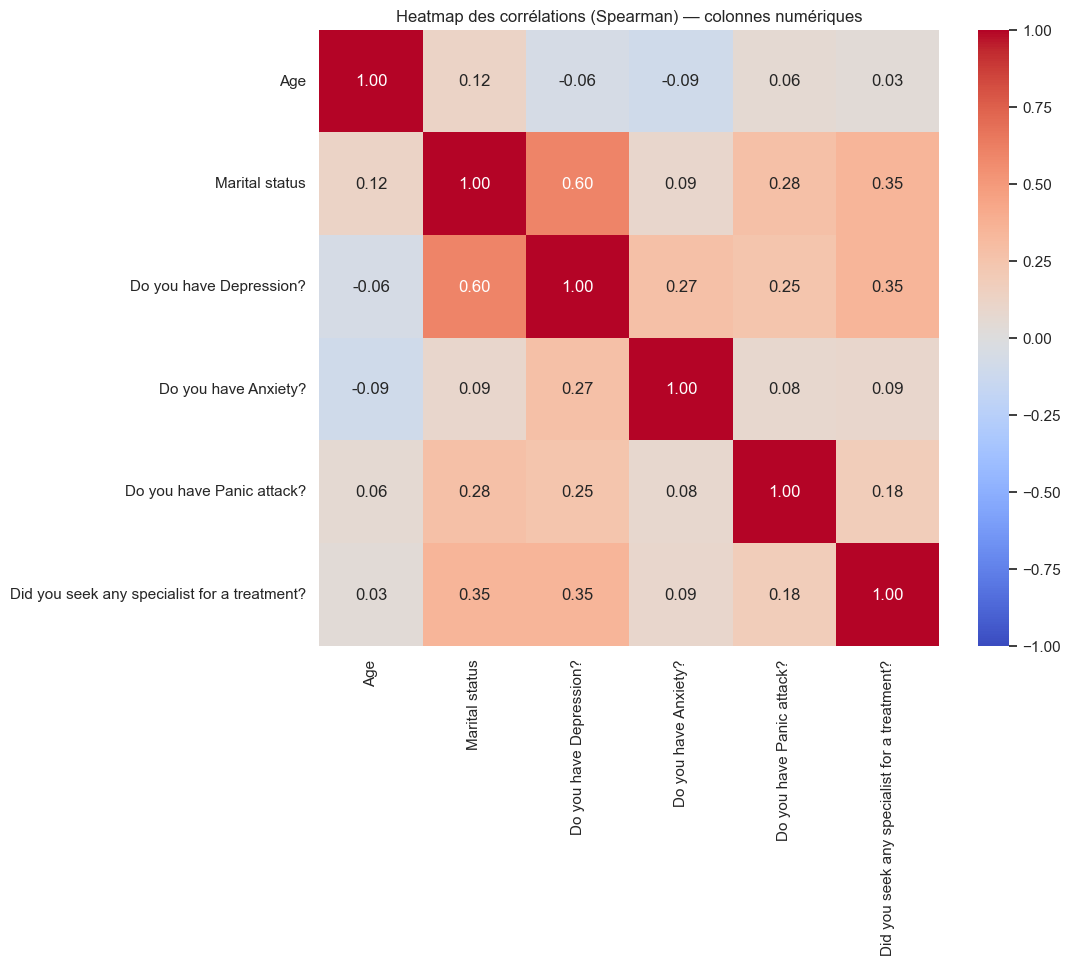

Paires non trouvées ou non numériques pour ['work', 'charge', 'workload'] / ['stress', 'stres']
Paires non trouvées ou non numériques pour ['sleep', 'sommeil'] / ['anx', 'anxiet', 'anxiety']
Paires non trouvées ou non numériques pour ['isol', 'isolement', 'lonely'] / ['depress', 'depression']
Clustering réalisé sur un sous-échantillon. Distribution des clusters : [15 69 16]


In [ ]:
# Corrélations robustes sur colonnes numériques
if not df.empty:
    num = df_clean.select_dtypes(include=[np.number])
    if num.shape[1] >= 2:
        corr = num.corr(method='spearman')
        plt.figure(figsize=(10,8))
        sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
        plt.title('Heatmap des corrélations (Spearman), colonnes numériques')
        plt.show()
        # Exemples spécifiques : workload vs stress, sleep vs anxiety, recherche automatique par nom
        def find_pair(a_keywords,b_keywords):
            a = find_col(a_keywords)
            b = find_col(b_keywords)
            return a,b
        pairs = [ (['work','charge','workload'], ['stress','stres']), (['sleep','sommeil'], ['anx','anxiet','anxiety']), (['isol','isolement','lonely'], ['depress','depression']) ]
        for a_k,b_k in pairs:
            a_col,b_col = find_pair(a_k,b_k)
            if a_col and b_col and a_col in num.columns and b_col in num.columns:
                print(f'Correlation entre {a_col} et {b_col} : {num[a_col].corr(num[b_col], method="spearman"):.2f}')
            else:
                print(f'Paires non trouvées ou non numériques pour {a_k} / {b_k}')
        # Clustering simple
        # Sélectionner un sous-ensemble de colonnes numériques pour le clustering (au moins 2)
        features = num.dropna(axis=0, how='any')
        if features.shape[0] >= 10 and features.shape[1] >= 2:
            scaler = StandardScaler()
            X = scaler.fit_transform(features.iloc[:200, :min(10, features.shape[1])])
            kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
            print('Clustering réalisé sur un sous-échantillon. Distribution des clusters :', np.bincount(kmeans.labels_))
        else:
            print('Pas assez de données numériques complètes pour un clustering fiable.')
    else:
        print('Moins de deux colonnes numériques, pas de corrélations calculées.')
else:
    print('DataFrame vide, pas danalyse.')

## 6) Limites & Biais
- Données auto-déclarées (self-report) — risque de biais de désirabilité sociale.
- Échantillon probablement non représentatif (biais de recrutement, géographique, culturel).
- Données non médicales — ce sont des indicateurs, pas des diagnostics.
- Manque d'information temporelle pour établir des tendances causales.

# Conclusion & Pistes
Quelques pistes daction basées sur la data (non médicales) :
- Renforcer les services de soutien étudiant et leur accessibilité anonyme.
- Promouvoir lhygiène du sommeil et des interventions préventives (atelier, sensibilisation).
- Mettre en place un suivi statistique anonyme régulier au niveau institutionnel.
- Utiliser des indicateurs simples (manque de sommeil, isolement, charge de travail) pour des alertes précoces.